# Sign Language Detection V3 [Word and Sentence Detection]

Requirements:
Upload the following files in directory:
- ASL Sign Language.png: https://drive.google.com/file/d/13kDtEymUInxx12bAMyCkN0Iz0B_Iz2Qg/view?usp=sharing
- Dataset: https://www.kaggle.com/grassknoted/asl-alphabet

## Data and Preprocessing 

ASL Alphabet
- Image data set for alphabets in the American Sign Language
- The data set is a collection of images of alphabets from the American Sign Language, separated in 29 folders which represent the various classes.
- he training data set contains 87,000 images which are 200x200 pixels. There are 29 classes, of which 26 are for the letters A-Z and 3 classes for SPACE,DELETE and NOTHING.
- Dataset url: https://www.kaggle.com/grassknoted/asl-alphabet

In [2]:
# importing dependencies

import numpy as np  # linear algebra
import pandas as pd  # dataset handling
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import tensorflow as tf # tensorflow
import cv2 # computer vision
import os # interacting with the operating system

from tensorflow.keras import Sequential # squential neural network
from tensorflow.keras.layers import Conv2D  # convolutional layer
from tensorflow.keras.layers import MaxPool2D  # pooling layer
from tensorflow.keras.layers import Dense # feed forward layer
from tensorflow.keras.layers import Flatten # flatten 2d/3d array into 1d array
from tensorflow.keras.callbacks import EarlyStopping # early stopping to reduce overfitting
from tensorflow.keras.utils import plot_model # plot model architecture
from tensorflow.keras.models import load_model # loading saved model

from sklearn.preprocessing import LabelEncoder # add placeholder values for categorical variables
from sklearn.model_selection import train_test_split # split dataset into training and testing dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # performance metrics

In [2]:
# extracting files, images and labels 

train_path = r'C:\Users\dariu\Jupyter Notebook\Sign Language Detection\asl_alphabet_train\asl_alphabet_train'

filename_list = []
image_list = []
label_list = []
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
for label in labels:
    for filename in os.listdir(train_path+f'\\{label}'):
        file_path = train_path+f'\\{label}'+f'\\{filename}'
        letter = label
        image = cv2.imread(file_path)
        filename_list.append(filename)
        image_list.append(image)
        label_list.append(letter)

In [3]:
# creating meta dataset contiaing filenames, labels, and image

meta_data = pd.DataFrame({'filename':filename_list, 'label':label_list, 'image':image_list})
print(meta_data.shape)
meta_data.head()

(87000, 3)


,filename,label,image
0,A1.jpg,A,"[[[252, 2, 1], [248, 0, 1], [249, 0, 10], [245..."
1,A10.jpg,A,"[[[252, 6, 0], [248, 2, 0], [243, 0, 4], [242,..."
2,A100.jpg,A,"[[[253, 8, 0], [249, 2, 0], [250, 0, 5], [246,..."
3,A1000.jpg,A,"[[[254, 7, 0], [251, 3, 0], [247, 0, 5], [243,..."
4,A1001.jpg,A,"[[[254, 3, 0], [253, 2, 0], [249, 0, 5], [248,..."


In [4]:
# shuffling meta dataset

meta_data =meta_data.sample(frac=1).reset_index(drop=True)
meta_data.head()

,filename,label,image
0,H1716.jpg,H,"[[[253, 2, 0], [252, 3, 0], [245, 0, 7], [242,..."
1,G676.jpg,G,"[[[253, 3, 0], [253, 5, 0], [240, 0, 0], [242,..."
2,H1893.jpg,H,"[[[249, 5, 0], [253, 9, 0], [248, 0, 3], [247,..."
3,U2475.jpg,U,"[[[251, 0, 0], [253, 1, 2], [251, 0, 4], [253,..."
4,nothing2020.jpg,nothing,"[[[254, 5, 0], [249, 0, 0], [252, 2, 7], [249,..."


In [3]:
# function that preprocesses the data

def preprocess_image(image):
    """Takes in image array as input and returns resized and scaled image"""
    image = cv2.resize(image, (64,64))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(64,64,1)
    image = image.astype('float32')/255.0
    return image

In [16]:
# preprocessing the images

preprocessed_image_list = []
for image in meta_data['image']:
    img = preprocess_image(image)
    preprocessed_image_list.append(img)

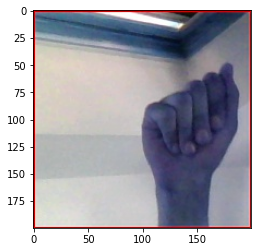

In [17]:
# sample image

plt.imshow(image_list[5])

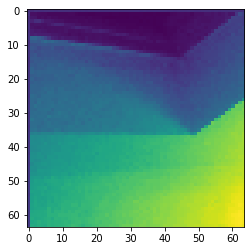

In [18]:
# sample preprocessed image 

plt.imshow(preprocessed_image_list[4])

In [19]:
# splitting meta dataset into inputs and targets

X = np.array(preprocessed_image_list)

le = LabelEncoder() 
y = meta_data['label'] # adding number placeholders for each category
y = le.fit_transform(y)

In [20]:
print(X.shape, y.shape)

(87000, 64, 64, 1) (87000,)


In [21]:
# splitting data into train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(69600, 64, 64, 1) (69600,) (17400, 64, 64, 1) (17400,)


## Model Training

In [23]:
# INPUT_SHAPE and OUTPUT_SHAPE hyperparameters

INPUT_SHAPE = X_train.shape[1:]
OUTPUT_SHAPE = len(labels)
print(INPUT_SHAPE, OUTPUT_SHAPE)

(64, 64, 1) 29


In [24]:
# creating CNN model with activation relu
# output layer activation is softmax as this is a multiclassification model

model = Sequential()
model.add(Conv2D(32, (5,5), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(OUTPUT_SHAPE, activation='softmax'))

In [25]:
# configuring early stopping to avoid overfitting

es = EarlyStopping(monitor='accuracy', patience=1, restore_best_weights=True)

In [26]:
# using adam as optimizer and sparse_categorical_crossentropy as loss function

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
# training the model

hist = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.3, verbose=2, callbacks=[es])

Epoch 1/15
762/762 - 23s - loss: 1.4764 - accuracy: 0.5643 - val_loss: 0.5676 - val_accuracy: 0.8219
Epoch 2/15
762/762 - 8s - loss: 0.3079 - accuracy: 0.9055 - val_loss: 0.2376 - val_accuracy: 0.9241
Epoch 3/15
762/762 - 8s - loss: 0.1373 - accuracy: 0.9570 - val_loss: 0.1870 - val_accuracy: 0.9399
Epoch 4/15
762/762 - 8s - loss: 0.1022 - accuracy: 0.9681 - val_loss: 0.1139 - val_accuracy: 0.9660
Epoch 5/15
762/762 - 8s - loss: 0.0611 - accuracy: 0.9812 - val_loss: 0.0660 - val_accuracy: 0.9805
Epoch 6/15
762/762 - 8s - loss: 0.0528 - accuracy: 0.9831 - val_loss: 0.0928 - val_accuracy: 0.9736
Epoch 7/15
762/762 - 8s - loss: 0.0418 - accuracy: 0.9874 - val_loss: 0.0744 - val_accuracy: 0.9778
Epoch 8/15
762/762 - 8s - loss: 0.0451 - accuracy: 0.9866 - val_loss: 0.0545 - val_accuracy: 0.9839


In [28]:
# summary of the model

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)             

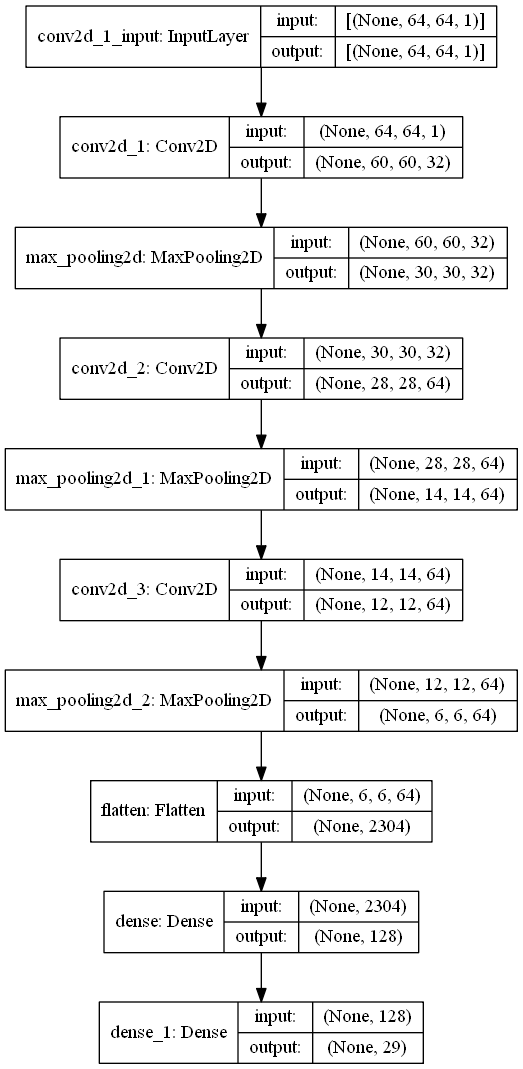

In [29]:
# model architecture

plot_model(model, show_shapes=True)

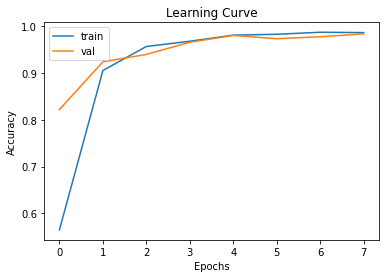

In [30]:
# Accuracy learning curve

plt.title("Learning Curve")
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

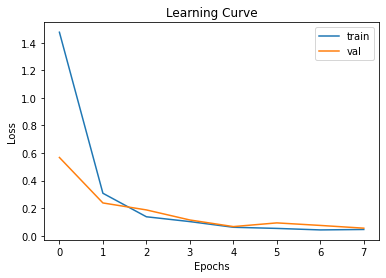

In [31]:
# Loss learning curve

plt.title("Learning Curve")
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Testing

In [32]:
# evaluating the model

loss, accuracy = model.evaluate(X_test, y_test, verbose=2)

544/544 - 2s - loss: 0.0682 - accuracy: 0.9793


## Model Performance Metrics

In [33]:
y_pred_prob = model.predict(X_test) # returns an array containing probability for each category being output
y_pred = []
for i in y_pred_prob:
    out = np.argmax(i) # taking the highest probability category as output
    y_pred.append(out)
y_pred = np.array(y_pred)

In [34]:
# accuracy of the model

print(f'Accuracy :{round(accuracy_score(y_test, y_pred),4)*100}%')

Accuracy :97.92999999999999%


In [35]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       591
           1       1.00      0.98      0.99       645
           2       1.00      0.99      0.99       611
           3       0.99      1.00      0.99       603
           4       0.98      0.98      0.98       578
           5       0.99      0.99      0.99       622
           6       0.99      0.99      0.99       580
           7       1.00      0.99      1.00       589
           8       0.99      0.99      0.99       580
           9       1.00      0.99      0.99       600
          10       0.99      0.96      0.98       561
          11       1.00      0.99      1.00       607
          12       0.99      0.96      0.97       565
          13       1.00      0.97      0.98       637
          14       0.99      0.98      0.99       624
          15       1.00      0.99      0.99       531
          16       0.99      1.00      0.99       597
          17       0.99    

<ipython-input-36-c0058e95a4d0>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Confusion Matrix', Fontsize=20)


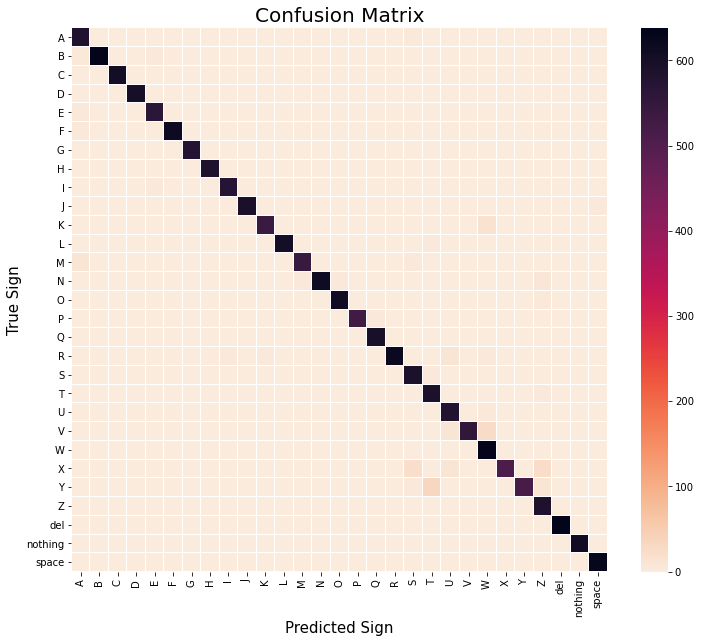

In [36]:
# confusion matrix

cm = confusion_matrix(y_test, y_pred)

# heatmap of confusion matrix
plt.figure(figsize=(12,10))
plt.title('Confusion Matrix', Fontsize=20)
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='rocket_r', linecolor='white', linewidth=0.005)
plt.xlabel('Predicted Sign', fontsize=15)
plt.ylabel('True Sign', fontsize=15)
plt.show()

## Saving the model for future use

In [37]:
# saving the model

model.save('sign_lang_detect_model.h5')

## Loading the model and predicting using the model

In [4]:
# loading the model 

model = load_model('sign_lang_detect_model.h5')

In [5]:
# function that classifies image to detect sign

def classify(image):
    """
    takes image array as input and returns class of the output
    note: returns '' for 'nothing' and 'space' labels
    """
    image = preprocess_image(image)
    image = image.reshape(1,64,64,1)
    pred = model.predict([image])
    idx = np.argmax(pred)
    if idx == 26 or idx==27:
        return ""
    elif idx == 28:
        return " "
    else:
        return labels[idx]

In [6]:
# labels

labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

In [46]:
# taking image as input and classifying it

test_image1 = cv2.imread(r'C:\Users\dariu\Jupyter Notebook\Sign Language Detection\asl_alphabet_test\asl_alphabet_test\A_test.jpg')
classify(test_image1)

'A'

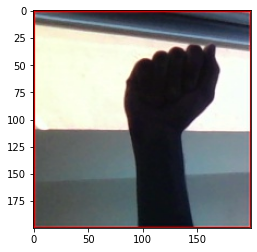

In [47]:
# image

plt.imshow(test_image1)

In [48]:
# taking image as input and classifying it

test_image2 = cv2.imread(r'C:\Users\dariu\Jupyter Notebook\Sign Language Detection\asl_alphabet_test\asl_alphabet_test\H_test.jpg')
classify(test_image2)

'H'

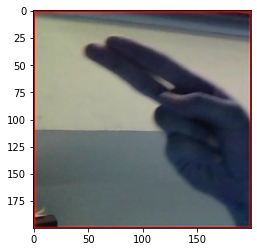

In [49]:
# image

plt.imshow(test_image2)

## Real-time sign language detection

In [50]:
# sign language detection on live video

cap = cv2.VideoCapture(0) # 1 for second webcam, use 0 if you have only one webcame

while True:
    ret, frame = cap.read()
    
    # sign language guide
    image2 = cv2.imread('ASL Sign Language.png')
    image2 = cv2.resize(image2,(1400,800))
    cv2.imshow('Guide', image2)
    
    frame = cv2.flip(frame, 1)
    top, right, bottom, left = 75, 350, 300, 590
    sign = frame[top:bottom, right:left]
    sign=cv2.flip(sign,1)
    cv2.imshow('Sign',sign)  # classification window
    alpha=classify(sign)  # classifying frame
    cv2.rectangle(frame, (left, top), (right, bottom), (0,255,255), 2) # creating classification box
    font=cv2.FONT_HERSHEY_SIMPLEX 
    cv2.putText(frame,alpha,(0,130),font,5,(0,0,255),2) # adding text output 
    cv2.imshow('img',frame)
    
    if cv2.waitKey(1) & 0xFF==ord('q'): # press q to stop capture
        break
cap.release()
cv2.destroyAllWindows()

## Real time word and sentence detection

In [8]:
# sign language detection on live video

cap = cv2.VideoCapture(0) # 1 for second webcam, use 0 if you have only one webcame

i = 0
last_frame_alpha = None
sentence_list = []

while True:
    ret, frame = cap.read()
    
    # sign language guide
    image2 = cv2.imread('ASL Sign Language.png')
    image2 = cv2.resize(image2,(1400,800))
    cv2.imshow('Guide', image2)
    
    frame = cv2.flip(frame, 1)
    top, right, bottom, left = 75, 350, 300, 590
    sign = frame[top:bottom, right:left]
    sign=cv2.flip(sign,1)
    cv2.imshow('Sign',sign)  # classification window
    alpha=classify(sign)  # classifying frame
    cv2.rectangle(frame, (left, top), (right, bottom), (0,255,255), 2) # creating classification box
    font=cv2.FONT_HERSHEY_SIMPLEX 
    cv2.putText(frame,alpha,(0,130),font,5,(0,0,255),2) # adding text output 
    cv2.imshow('img',frame)
    
    
    if last_frame_alpha==alpha:
        i+=1
    else:
        i=0
        
    if i>30 and alpha!="":
        print(alpha)
        sentence_list.append(alpha)
        i=0
        
    last_frame_alpha = alpha
    
    if cv2.waitKey(1) & 0xFF==ord('q'): # press q to stop capture
        break
cap.release()
cv2.destroyAllWindows()
print("".join(sentence_list))

H
I
 
M
Y
 
N
A
M
E
 
I
S
 
D
A
R
I
U
S
HI MY NAME IS DARIUS
